# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: Do autoencoders clean Gaussians?
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [23]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchinfo import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create Gaussian blurs with varying widths and occluding bars

In [24]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)
imagesWithBars = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # save the images without bars
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1
  
  # add to the tensor
  imagesWithBars[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

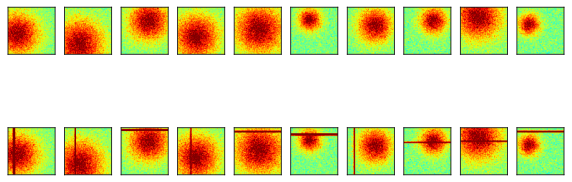

In [25]:
# visualize some images
fig,axs = plt.subplots(2,10,figsize=(10,4))

for i in range(10):
  whichpic = np.random.randint(nGauss)

  G = np.squeeze( images[whichpic,:,:] )
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].set_xticks([])
  axs[0,i].set_yticks([])
  
  G = np.squeeze( imagesWithBars[whichpic,:,:] )
  axs[1,i].imshow(G,vmin=-1,vmax=1,cmap='jet')  
  axs[1,i].set_xticks([])
  axs[1,i].set_yticks([])

plt.show()

In [26]:
axs

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

# Create the DL model

In [27]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,8,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(8,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)  
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,8,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(8,1,3,2),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

 
torch.Size([10, 1, 91, 91])


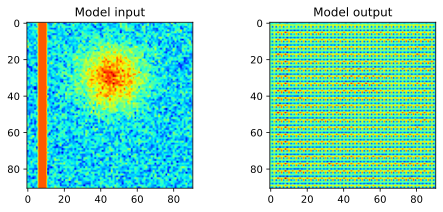

In [28]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

yHat = net(imagesWithBars[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(imagesWithBars[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [29]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
gausnet                                  [1, 91, 91]               --
├─Sequential: 1-1                        [4, 22, 22]               --
│    └─Conv2d: 2-1                       [8, 91, 91]               80
│    └─ReLU: 2-2                         [8, 91, 91]               --
│    └─MaxPool2d: 2-3                    [8, 45, 45]               --
│    └─Conv2d: 2-4                       [4, 45, 45]               292
│    └─ReLU: 2-5                         [4, 45, 45]               --
│    └─MaxPool2d: 2-6                    [4, 22, 22]               --
├─Sequential: 1-2                        [1, 91, 91]               --
│    └─ConvTranspose2d: 2-7              [8, 45, 45]               296
│    └─ReLU: 2-8                         [8, 45, 45]               --
│    └─ConvTranspose2d: 2-9              [1, 91, 91]               73
Total params: 741
Trainable params: 741
Non-trainable params: 0
Total mult-adds (Un

# Create a function that trains the model

In [30]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)    
    
    XBars = imagesWithBars[pics2use,:,:,:]
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(XBars)    # input image with bars
    loss = lossfun(yHat,X) # loss compare with image without bars
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [31]:
# test the model on a bit of data
losses,net = function2trainTheModel()

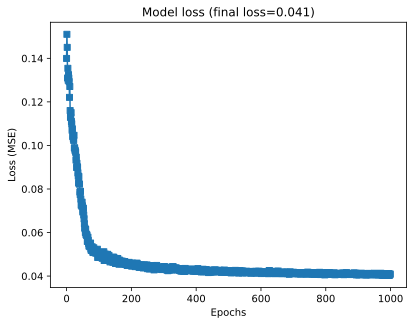

In [32]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

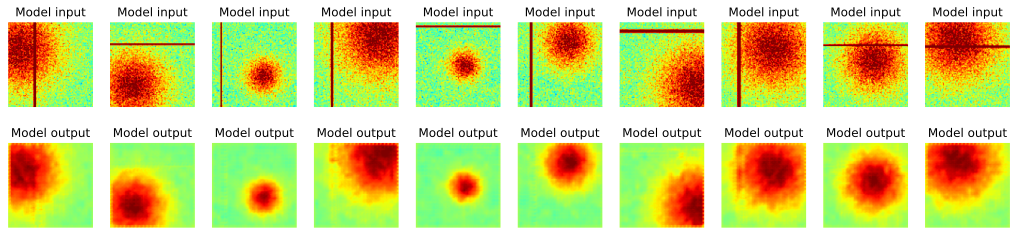

In [33]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imagesWithBars[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
  
  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

# Additional explorations

In [34]:
# 1) There are no test data here, so how do you know whether the model overfit the training set? Fortunately, you can
#    simply create as much new data as you want! That's one of the advantages of generating data ;)
#    Generate a new dataset to use as a test set. How does the MSE loss compare on the test set? Did we overfit here?
# 
# 2) The code here uses MaxPool. Are the results noticeably different if you use AvgPool instead?
# 
# 3) The final output doesn't have a nonlinearity (e.g., relu, sigmoid, tanh). Does it need one? Would that help? What
#    are some arguments for and against having a nonlinear activation function on the output of the decover? Try adding
#    one and see if it improves (via the final loss and visual inspection) the result.
# 
# 4) I mentioned in the lecture "What are autoencoders and what do they do?" (section "Autoencoders") that BCEloss can be
#    used when the data are between 0 and 1. Normalize the images so they are appropriately scaled, and then use BCEloss
#    instead of MSEloss (does anything else in the model architecture need to change?). Which loss function gives a 
#    better result?
# 